In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp



(CVXPY) Dec 03 07:44:58 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")


In [4]:
N = 30
tf = 5
delT = tf/N

## obstacle setting

In [5]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []


c_list.append([1.8,0.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([2*2/3,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([4.2,0.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([3.8,3.5])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([10*2/3,0.5])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([6.5,4])
H_list.append(get_H_obs(0.5,0.5))



c_list.append([4*2/3,1.7])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8*2/3,2.3])
H_list.append(get_H_obs(0.5,0.5))

c_list.append([0.5,2])
H_list.append(get_H_obs(0.5,0.5))
c_list.append([8,2.3])
H_list.append(get_H_obs(0.5,0.5))


## initial and final conditions 

In [6]:
myModel = UnicycleModel.unicycle1('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)



In [7]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 8.0
xf[1] = 4.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.3**2,0.3**2,np.deg2rad(20)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [8]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [9]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [10]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [11]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)
tnom = np.array(range(N+1))*delT

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-07
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │4079.873   │5.000     │76.8     │0          │-4.08e+03   │0(0.60  )│0(3.073 )│0(0.354 )│
│2     │85.631     │5.000     │84.5     │0          │3.99e+03    │1(-13.05)│0(1.144 )│0(0.059 )│
│3     │104.699    │5.000     │105      │0          │-19.1       │1(-12.29)│0(0.092 )│0(0.004 )│
│4     │104.992    │5.000     

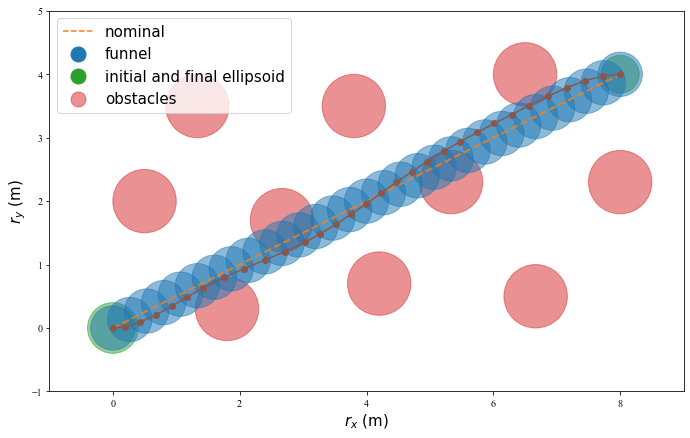

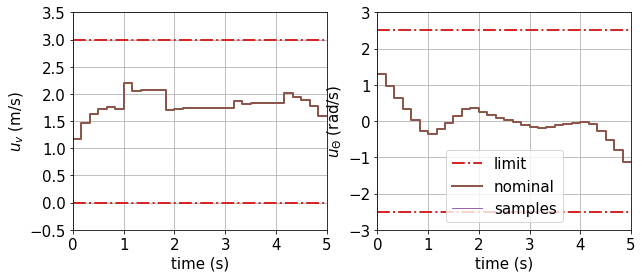

In [12]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.plot(xnom[:,0],xnom[:,1],'o-',color='tab:brown',label='traj w/o funnel')
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.plot(tnom, unom[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tnom, unom[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(tnom, [*unom[:N,0],unom[N-1,0]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)

plt.subplot(122)
plt.plot(tnom, unom[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tnom, unom[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(tnom, [*unom[:N,1],unom[N-1,1]],'-',color='tab:brown',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

## run

In [13]:
total_iter = 20

tol_funl = 1e-8
tol_traj = 1e-8
tol_vc = 1e-8
tol_dyn = 1e-8

traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=True)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
nonlinear funnel
Is DPP?  True


In [14]:
history = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |188.288    |4.591      |-10.8(1)|2.31      (0)|2.66      (0)|-4.719(0)|0.99508734|
|2   |133.530    |4.520      |-11  (1)|1.43      (0)|1.17      (0)|-4.877(0)|0.50589503|
|3   |138.632    |4.518      |-10.9(1)|-0.101    (0)|-0.41     (0)|-4.725(0)|0.04640167|
|4   |138.172    |4.521      |-12.5(1)|-1.53     (0)|-1.85     (0)|-4.965(0)|0.01450061|
|5   |137.948    |4.523      |-12.4(1)|-3.05     (0)|-2.96     (0)|-4.841(0)|0.00129456|
|6   |137.947    |4.522      |-11.6(1)|-3.32     (0)|-3.9      (0)|-5.215(0)|0.00058693|
|7   |137.934    |4.522      |-11.6(1)|-3.72     (0)|-4.52     (0)|-5.597(0)|0.00033029|
|8   |137.943    |4.522      |-11.3(1)|-4.41     (0)|-5.02     (0)|-6.401(0)|0.00016585|
|9   |137.948    |4.522      |-11.1(1)|-5.24     (0)|-5.85     (0)|-7.480(0)|0.00008044|
|10  |137.950    |4.5

In [15]:
del_traj_list = [history[i]['traj_diff'] for i in range(len(history))]
del_funl_list = [history[i]['funl_diff'] for i in range(len(history))]
vc_list = [history[i]['vc'] for i in range(len(history))]
dyn_error_list = [history[i]['dyn_error'] for i in range(len(history))]

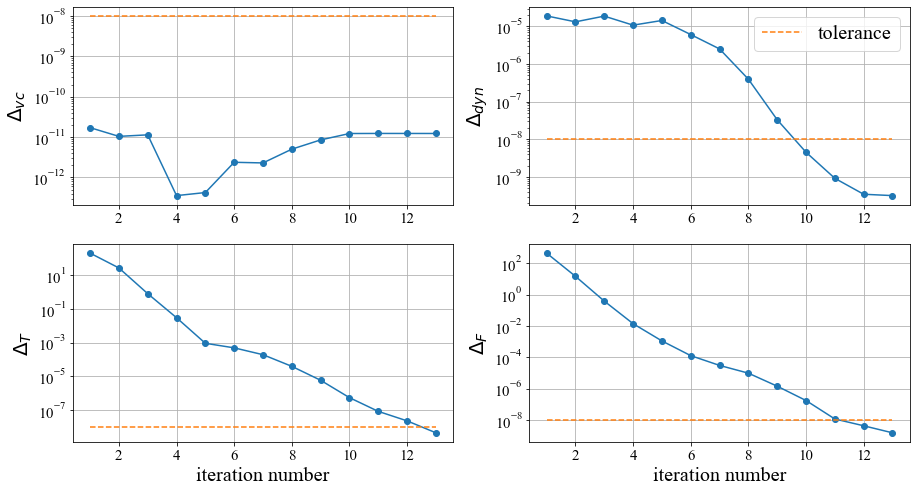

In [16]:
i_index = np.array([i+1 for i in range(len(history))])
fS = 20
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.plot(i_index,vc_list,'o-')
plt.plot(i_index,i_index*0+tol_vc,'--')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{vc}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(222)
plt.plot(i_index,dyn_error_list,'o-')
plt.plot(i_index,i_index*0+tol_dyn,'--',label='tolerance')
# plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_{dyn}$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=fS)


plt.subplot(223)
plt.plot(i_index,del_traj_list,'o-')
plt.plot(i_index,i_index*0+tol_traj,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_T$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(224)
plt.plot(i_index,del_funl_list,'o-')
plt.plot(i_index,i_index*0+tol_funl,'--')
plt.xlabel('iteration number',fontsize=fS,fontname='Times New Roman')
plt.ylabel(r'$\Delta_F$',fontsize=fS,fontname='Times New Roman')
plt.yscale('log')
# plt.ylim([10**(-6), 10**(4)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)

# Computational time

In [17]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []

for his in history :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.006757094309880183
mean_trajopt 0.05002423433157114
mean_funlopt 4.379884334710928
mean_lipschitz 0.9859147988832914


# Evaluate the generated traj and funl

In [18]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [19]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']

(-1.0, 9.0, -1.0, 5.0)

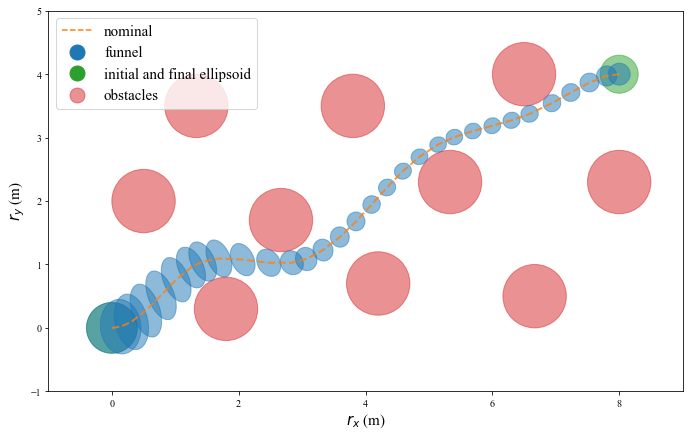

In [20]:
fS = 15
plt.figure(0,figsize=(15,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])

# comparison with linear case

In [21]:
traj_solver= trajopt('unicycle',N,tf,10,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e0,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=False)

funl_solver = funlopt(ix,iu,iq,ip,iw,N,myCost.S,myCost.R,funl_scaling,
                      alpha=0.99,
                      lambda_mu=0.1,
                      w_tr=1e-4,
                      flag_nonlinearity=False)
funl_solver.cvx_initialize(Qini,Qf)
lip_estimator = Lipschitz(ix,iu,iq,ip,iw,N,num_sample=100,flag_uniform=True)

from jointsynthesis import jointsynthesis
JS = jointsynthesis(myModel,traj_solver,funl_solver,lip_estimator,total_iter,
                   tol_traj,tol_funl,tol_vc,tol_dyn,verbosity=True)

Is DPP?  True
linear funnel
Is DPP?  True


In [22]:
history_linear = JS.run(xi,xf,x0,u0,Q0,Y0,K0)

|iter| traj_cost | funl_cost |   vc   |   Delta_T   |   Delta_F   | e_prop  |gamma diff|
|    |           |           | log10  |   log10     |   log10     | log10   |          |
|1   |188.288    |3.886      |-10.8(1)|2.31      (0)|2.63      (0)|-4.719(0)|0.99508734|
|2   |128.912    |3.922      |-11.4(1)|1.49      (0)|1.01      (0)|-3.536(0)|0.54532255|
|3   |133.720    |3.892      |-13.7(1)|-0.305    (0)|-0.551    (0)|-4.563(0)|0.05884204|
|4   |133.341    |3.893      |-11.9(1)|-2.03     (0)|-2.57     (0)|-4.653(0)|0.02351237|
|5   |131.664    |4.013      |-12.6(1)|0.622     (0)|0.171     (0)|-3.548(0)|0.02658050|
|6   |134.317    |4.001      |-13  (1)|-0.727    (0)|-1.02     (0)|-5.251(0)|0.01769619|
|7   |133.958    |4.001      |-13  (1)|-2.66     (0)|-2.85     (0)|-4.592(0)|0.00590598|
|8   |133.920    |4.002      |-12.7(1)|-3.19     (0)|-3.7      (0)|-5.201(0)|0.00044128|
|9   |133.914    |4.002      |-12.4(1)|-4.02     (0)|-4.86     (0)|-6.036(0)|0.00019746|
|10  |133.921    |4.0

In [23]:
xbar_linear = history_linear[-1]['x']
ubar_linear = history_linear[-1]['u']
Qbar_linear = history_linear[-1]['Q']
Ybar_linear = history_linear[-1]['Y']
Kbar_linear = history_linear[-1]['K']

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

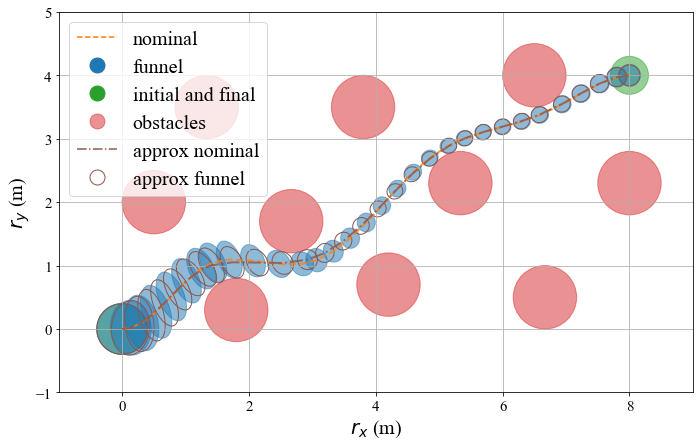

In [24]:
fS = 20
plt.figure(0,figsize=(15,7))
plot_comparison(xbar,xbar_linear,c_list,H_list,Qbar,Qbar_linear,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,fS=fS)
plt.legend(fontsize=fS)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"
plt.axis([-1.0, 9.0, -1.0, 5.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Sample from initial set

In [25]:
x0_sample = []
num_sample = 100
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)

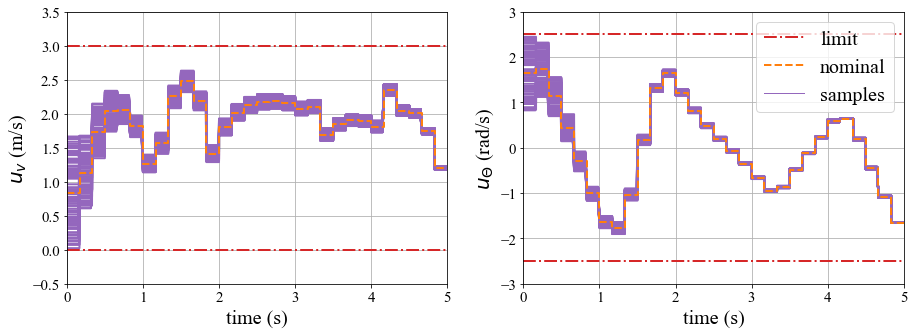

In [26]:
fS = 20
plt.figure(0,figsize=(15,5))
alpha = 1.0
t_index = np.array(range(N+1))*delT
for i in range(num_sample) :
    tsam_e = tsam[i]
    xsam_e = xsam[i]
    usam_e = usam[i]
#     plot_state_input(tsam_e,xsam_e,usam_e,None,None,N,delT,alpha,plt,flag_step=False)

    plt.subplot(121)
    plt.plot(tsam_e, usam_e[:,0],color='tab:purple',alpha=alpha,linewidth=2.0)
    plt.subplot(122)
    plt.plot(tsam_e, usam_e[:,1],color='tab:purple',alpha=alpha,linewidth=2.0)
plt.subplot(121)
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.plot(tsam_e, usam_e[:,0]*0+myConst.vmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.step(t_index, [*ubar[:N,0],ubar[N-1,0]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_v$ (m/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -0.5, 3.5])
plt.grid(True)
plt.subplot(122)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmax,'-.',color='tab:red',alpha=1.0,linewidth=2.0)
plt.plot(tsam_e, usam_e[:,1]*0+myConst.wmin,'-.',color='tab:red',alpha=1.0,linewidth=2.0,label='limit')
plt.step(t_index, [*ubar[:N,1],ubar[N-1,1]],'--',color='tab:orange',alpha=1.0,where='post',linewidth=2.0,label='nominal')
plt.plot(1e3, 1e3,'-',color='tab:purple',alpha=1.0,linewidth=1.0,label='samples')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('$u_{\Theta}$ (rad/s)', fontsize = fS)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.0, tf, -3, 3])
plt.legend(fontsize=fS)
plt.rcParams["font.family"] = "Times New Roman"
plt.grid(True)


## sample from approx funnel

In [34]:
x0_sample = []
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar_linear[0] + scipy.linalg.sqrtm(Qbar_linear[0])@z
    x0_sample.append(x_s)
tsam_linear,xsam_linear,usam_linear,wsam_linear,xsamp_linear = get_sample_trajectory(xi,x0_sample,
                                                                    xbar_linear,ubar_linear,
                                                                    Qbar_linear,Ybar_linear,myModel,N,ix,iu,iw,delT,
                                                                    flag_noise=True)

there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation
there is invariance violation


In [35]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",radii[i])
        radii_list.append(radii)
    return radii_list
radii_list = get_radii_list(xsamp,xbar,Qbar)
radii_list_linear = get_radii_list(xsamp_linear,xbar_linear,Qbar_linear)

invariance violation 1.0105703908957564
invariance violation 1.0131665240624108
invariance violation 1.0003800321997758
invariance violation 1.017734630028751
invariance violation 1.011801771837222


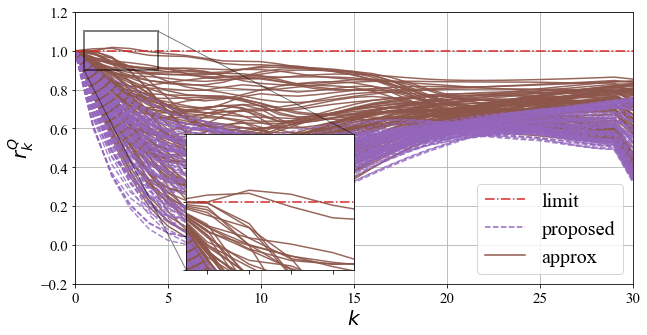

In [36]:
fS = 20
idx_plot = [i for i in range(N+1)]
fig, ax = plt.subplots(figsize=[10, 5])
for radii in radii_list_linear :
    ax.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    ax.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
plt.xlabel('$k$', fontsize = fS)
plt.ylabel('$r^Q_k$', fontsize = fS)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,30,-0.2,1.2])
plt.plot(1e3,1e3,'--',color='tab:purple',alpha=1.0,label='proposed')
plt.plot(1e3,1e3,color='tab:brown',alpha=1.0,label='approx')
plt.legend(fontsize=fS)
# axins = ax.inset_axes([5, 15, 0.0, 0.6])
axins = ax.inset_axes([0.2, 0.05, 0.3, 0.5])

for radii in radii_list_linear :
    axins.plot(idx_plot,radii,color='tab:brown',alpha=0.9)
for radii in radii_list :
    axins.plot(idx_plot,radii,'--',color='tab:purple',alpha=0.8)
axins.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')

axins.set_xlim(0.5, 4.5)
axins.set_ylim(0.9, 1.1)
axins.set_xticklabels([])
axins.set_yticklabels([])
ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=2.0)
plt.grid(True)
plt.rcParams["font.family"] = "Times New Roman"

In [40]:
for idx in range(len(history)+1) :
    if idx == 0 :
        xnew,unew,Qnew = x0,u0,Q0
    else :
        xnew,unew,Qnew = history[idx-1]['x'],history[idx-1]['u'],history[idx-1]['Q']

    plt.figure(figsize=(7,7))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["legend.loc"] = 'upper left'
    plot_traj_set(xnew,unew,c_list,H_list,Qnew,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
    plt.title(str(idx)+' iterations',fontsize=15)
    plt.axis([-1.0, 9.0, -1.0, 5.0])
    plt.savefig('../images/iteration/cluttered/'+str(idx)+'.png',dpi=500)
    plt.close()